In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sb
from preprocessing import *
from model.convolutional_neural_network import *
from sklearn.model_selection import KFold
from model.Executor import *
import warnings  
warnings.filterwarnings("ignore")

import torch.nn.functional as functional


# Training Data

The statistics on the size of our dataset.

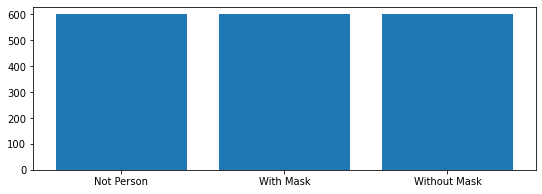

In [2]:
names = ['Not Person', 'With Mask', 'Without Mask']
N = []
N.append(len(os.listdir("./dataset/NotPerson")))
N.append(len(os.listdir("./dataset/WithMask")))
N.append(len(os.listdir("./dataset/WithoutMask")))
plt.figure(figsize=(9, 3))
plt.bar(names, N)
plt.show()

Create datasets for training and testing the model.

In [3]:
dataset = load_data("./dataset")
tr_ds, te_ds = split_data(dataset)
tr_loader = train_dataloarder(tr_ds)
te_loader = test_dataloarder(te_ds)

# Deep Learning

Implementing and training the CNN model.

In [36]:
num_epochs = 20
exec_obj = Executor()
all_loss,iter_loss,accuracy = exec_obj.training_model_executor(
    tr_loader,
    num_epochs
)


  0/20... rate=0 Hz, eta=?, total=0:00:00, wall=17:16 EST
current iter acc: 78.3704
current iter loss: 80.4656
  1/20... rate=0.04 Hz, eta=0:08:55, total=0:00:28, wall=17:17 EST
current iter acc: 87.6296
current iter loss: 69.5831
  2/20... rate=0.03 Hz, eta=0:08:42, total=0:00:58, wall=17:17 EST
current iter acc: 81.4074
current iter loss: 62.0012
  3/20... rate=0.04 Hz, eta=0:08:00, total=0:01:24, wall=17:17 EST
current iter acc: 87.8519
current iter loss: 57.3308
  4/20... rate=0.04 Hz, eta=0:07:23, total=0:01:50, wall=17:18 EST
current iter acc: 94.1481
current iter loss: 52.9651
  5/20... rate=0.04 Hz, eta=0:06:50, total=0:02:16, wall=17:18 EST
current iter acc: 90.3704
current iter loss: 49.4752
  6/20... rate=0.04 Hz, eta=0:06:29, total=0:02:46, wall=17:19 EST
current iter acc: 94.9630
current iter loss: 46.2112
  7/20... rate=0.04 Hz, eta=0:06:05, total=0:03:16, wall=17:19 EST
current iter acc: 96.1481
current iter loss: 43.5602
  8/20... rate=0.04 Hz, eta=0:05:41, total=0:03:4

In [37]:
testdata_accuracy = exec_obj.calculate_model_accuracy(te_loader)
print("Model accuracy for test dataset :",testdata_accuracy)
print(len(te_ds))

Model accuracy for test dataset : 96.66666666666667
450


# Evaluation

Confusion matrix.

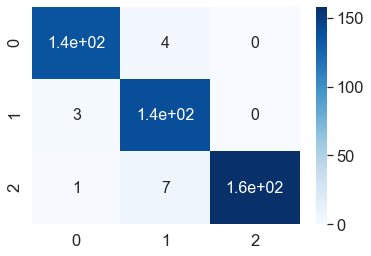

In [38]:
calc_model_weights, actual_results = next(iter(te_loader))
model_net = exec_obj.network(calc_model_weights)
pred_vals = torch.argmax(model_net, dim = 1)

sb.set(font_scale=1.5) 
sb.heatmap(
    confusion_matrix(actual_results.numpy(),pred_vals.numpy()),
    annot=True,
    annot_kws={"size": 16},
    cmap="Blues"
)  
plt.show()

Creating a table of results in order to show the accuracy, precision, recall and f1-score.

In [39]:
report = classification_report(
    actual_results.numpy(),
    pred_vals.numpy(), 
    target_names=['with mask','without mask','not a person']
)
print(report)  

              precision    recall  f1-score   support

   with mask       0.97      0.97      0.97       141
without mask       0.93      0.98      0.95       143
not a person       1.00      0.95      0.98       166

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



# Saving the trained model.

In [40]:
save_path = os.path.join(os.path.abspath("."), "trained_model.pt")
torch.save(exec_obj.network.state_dict(), save_path)

In [41]:
exec_obj = Executor()

model = convolutional_neural_network.convolutional_neural_network()

model.load_state_dict(torch.load(save_path))

exec_obj.network = model

In [42]:
dataset_female = load_data("./biasTestData/Female")
dataset_male = load_data("./biasTestData/Male")
dataset_all = load_data("./biasTestData/All")

te_loader_female = test_dataloarder(dataset_female)
te_loader_male = test_dataloarder(dataset_male)
te_loader_all = test_dataloarder(dataset_all)

print("Model accuracy for test dataset(Female):", exec_obj.calculate_model_accuracy(te_loader_female))
print("Model accuracy for test dataset(Male):", exec_obj.calculate_model_accuracy(te_loader_male))
print("Model accuracy for test dataset(All):", exec_obj.calculate_model_accuracy(te_loader_all))



Model accuracy for test dataset(Female): 98.75
Model accuracy for test dataset(Male): 97.08333333333333
Model accuracy for test dataset(All): 97.6470588235294


# Evaluation the model - Female 

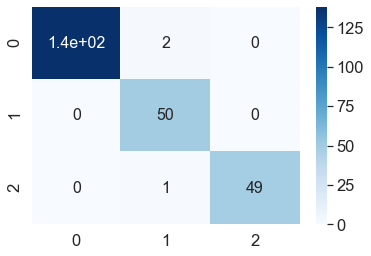

In [43]:
calc_model_weights, actual_results = next(iter(te_loader_female))
model_net = exec_obj.network(calc_model_weights)
pred_vals = torch.argmax(model_net, dim = 1)

sb.set(font_scale=1.5) 
sb.heatmap(
    confusion_matrix(actual_results.numpy(),pred_vals.numpy()),
    annot=True,
    annot_kws={"size": 16},
    cmap="Blues"
)  
plt.show()

In [44]:
report = classification_report(
    actual_results.numpy(),
    pred_vals.numpy(), 
    target_names=['with mask','without mask','not a person']
)
print(report)  

              precision    recall  f1-score   support

   with mask       1.00      0.99      0.99       140
without mask       0.94      1.00      0.97        50
not a person       1.00      0.98      0.99        50

    accuracy                           0.99       240
   macro avg       0.98      0.99      0.98       240
weighted avg       0.99      0.99      0.99       240



# Evaluation the model - Male 

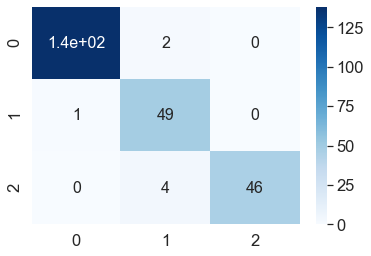

In [45]:
calc_model_weights, actual_results = next(iter(te_loader_male))
model_net = exec_obj.network(calc_model_weights)
pred_vals = torch.argmax(model_net, dim = 1)

sb.set(font_scale=1.5) 
sb.heatmap(
    confusion_matrix(actual_results.numpy(),pred_vals.numpy()),
    annot=True,
    annot_kws={"size": 16},
    cmap="Blues"
)  
plt.show()

In [47]:
report = classification_report(
    actual_results.numpy(),
    pred_vals.numpy(), 
    target_names=['with mask','without mask','not a person']
)
print(report)  

              precision    recall  f1-score   support

   with mask       0.99      0.99      0.99       140
without mask       0.89      0.98      0.93        50
not a person       1.00      0.92      0.96        50

    accuracy                           0.97       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.97      0.97      0.97       240



# Evaluation: K-fold cross-validation

In [12]:
def doKfold(executor_obj, dataset, num_of_folds=10, num_of_epochs=10):
    all_epoch_loss = []
    result_loss_vals = []
    result_acy_vals = []
    
    cnt = 0
    kfold_obj = KFold(num_of_folds, shuffle=True)
    kf_dataset = kfold_obj.split(dataset)

    for idx, (trn_idx_vals, tst_idx_vals) in enumerate(kf_dataset):
        print("Start---KFOLD iteration {}".format(idx))
        print("Index lengths -- train idxs:{} test idxs:{}".format(len(trn_idx_vals), len(tst_idx_vals)))
        
        trn_data_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.Subset(dataset, trn_idx_vals), 
            shuffle=True,
            batch_size=50, 
            num_workers=2
        )
        
        tst_data_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.Subset(dataset, tst_idx_vals), 
            shuffle=True,
            batch_size=50, 
            num_workers=2
        )
        
        all_loss, epoch_loss, accuracy_vals = exec_obj.training_model_executor(trn_data_loader,  num_of_epochs)
        avg_loss = np.mean(all_loss)
        avg_accuracy = np.mean(accuracy_vals)
        
        result_loss_vals.append(avg_loss)
        all_epoch_loss.append(epoch_loss)
        result_acy_vals.append(avg_accuracy)
        
        
    return kf_dataset, result_loss_vals, result_acy_vals
        
        

exec_obj = Executor()        
        
print(doKfold(exec_obj, tr_ds, num_of_folds=10, num_of_epochs=10))

Start---KFOLD iteration 0
Index lengths -- train idxs:1215 test idxs:135
  0/10... rate=0 Hz, eta=?, total=0:00:00, wall=02:57 EST
current iter acc: 56.3786
current iter loss: 92.8876
  1/10... rate=0.10 Hz, eta=0:01:32, total=0:00:10, wall=02:57 EST
current iter acc: 81.0700
current iter loss: 65.1167
  2/10... rate=0.09 Hz, eta=0:01:29, total=0:00:22, wall=02:57 EST
current iter acc: 94.0741
current iter loss: 51.2241
  3/10... rate=0.10 Hz, eta=0:01:13, total=0:00:31, wall=02:57 EST
current iter acc: 95.9671
current iter loss: 41.7213
  4/10... rate=0.10 Hz, eta=0:01:00, total=0:00:40, wall=02:58 EST
current iter acc: 98.5185
current iter loss: 35.0148
  5/10... rate=0.10 Hz, eta=0:00:50, total=0:00:50, wall=02:58 EST
current iter acc: 99.3416
current iter loss: 29.7824
  6/10... rate=0.10 Hz, eta=0:00:40, total=0:01:00, wall=02:58 EST
current iter acc: 100.0000
current iter loss: 25.7751
  7/10... rate=0.10 Hz, eta=0:00:29, total=0:01:09, wall=02:58 EST
current iter acc: 93.0864
cu

current iter acc: 100.0000
current iter loss: 0.0054
  2/10... rate=0.11 Hz, eta=0:01:12, total=0:00:18, wall=03:07 EST
current iter acc: 100.0000
current iter loss: 0.0054
  3/10... rate=0.11 Hz, eta=0:01:03, total=0:00:27, wall=03:07 EST
current iter acc: 100.0000
current iter loss: 0.0054
  4/10... rate=0.11 Hz, eta=0:00:54, total=0:00:36, wall=03:07 EST
current iter acc: 100.0000
current iter loss: 0.0054
  5/10... rate=0.11 Hz, eta=0:00:45, total=0:00:45, wall=03:07 EST
current iter acc: 100.0000
current iter loss: 0.0052
  6/10... rate=0.11 Hz, eta=0:00:36, total=0:00:54, wall=03:07 EST
current iter acc: 100.0000
current iter loss: 0.0051
  7/10... rate=0.11 Hz, eta=0:00:27, total=0:01:03, wall=03:07 EST
current iter acc: 100.0000
current iter loss: 0.0050
  8/10... rate=0.11 Hz, eta=0:00:18, total=0:01:12, wall=03:08 EST
current iter acc: 100.0000
current iter loss: 0.0050
  9/10... rate=0.11 Hz, eta=0:00:09, total=0:01:21, wall=03:08 EST
current iter acc: 100.0000
current iter 

NameError: name 'each_epoch_loss' is not defined

# Validating the Model